# Classification

## Imports

In [30]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import anndata as ad
#import scanpy as sc
from collections import Counter
os.environ['SCIPY_ARRAY_API'] = '1'
from imblearn import over_sampling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from flaml import AutoML
# import 

## Load embeddings and metadata

In [31]:
data = pd.read_csv('../data/processed/dataset_w_cdr_annotation.csv', index_col=0)
# data.index = data['Antibody  Name']
# data.drop('Antibody  Name', axis=1, inplace=True)
display(data)

,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,...,clus_vh,clus_vl,connected,partition,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3
Antibody Name,,,,,,,,,,,,,,,,,,,,,
BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,...,1442,682,0,Validation,GYTF----TSYA,INAG--NGNT,ASRREQWLGDLGYYYYGMDV,QSLVYS-DGNTY,KV-------S,MQGTH----SPWT
BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,...,1443,508,1,Train,GGSF----SDYF,INHS---GST,ARGQGYGRVLLWFGE,QSV------SSY,DA-------S,QQRS-----NWIT
BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,...,595,591,1,Test,GITV----SSNY,IYSG---GST,ARDLGE-AGGMDV,QGI------SSY,AA-------S,QQLNS----YPPA
BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,...,1444,683,2,Validation,GFTL----SSYA,VSGS--GGST,ALPTGASSSYSGPNY,TGAVT---SGHY,DT-------S,LLSYS---GAYVL
BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,...,1450,684,3,Validation,GFTF----SNYD,ISSD--GNNR,ARDEVIAVATGEGMDV,QSV------TRN,GA-------S,QQYSN---WPLYT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,...,2157,913,807,Validation,GFTF----SSSA,MAVG--GADR,AAMVRGGWWYFDL,QSV------HNY,DA-------S,QQRSD----WPWT
BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,...,2158,456,1,Train,GFTF----SDYY,ISSG--GGTI,ASDPGGLSELAAEYFHH,QSI------SNY,AA-------S,QQSHS----TPYT
BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,...,2159,456,1,Train,GFTF----SRFA,ISSN--GGST,ARESTEVTHWYFDL,QTI------SRY,AA-------S,QQSYV---TPEYT


In [32]:
embed_dir = '/home/azureuser/cloudfiles/code/Users/s184243/AI4ProtEng_AIntibody/data/interim/'
with open(os.path.join(embed_dir, 'embed_EMS_3B_seperate'), 'rb') as f:
    esm_output = pickle.load(f)

In [33]:
def extract_mean_rep(df, embedding, mean_method='full_seq'):
    hc_embedding = []
    lc_embedding = []

    if mean_method == 'cdr_seq':
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding.append(embedding[i][1:len(row['Heavy chain AA'])+1].numpy().mean(axis=0))
            lc_embedding.append(embedding[i+len(data)][1:len(row['Light chain AA'])+1].numpy().mean(axis=0))

    elif mean_method == 'cdr':
        for i, (index, row) in enumerate(df.iterrows()):
            for chain in ['Heavy', 'Light']:
                seq = row[f'{chain} chain AA']
                cdrs = row[[f'CDR{chain[0]}{i+1}' for i in range(3)]]
                cdr_index = [(seq.index(cdr.replace('-', '')), seq.index(cdr.replace('-', ''))+len(cdr)) for cdr in cdrs]
                if chain == 'Heavy':
                    chain_embedding = embedding[i][1:len(seq)+1].numpy()
                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).mean(axis=0)
                    hc_embedding.append(cdr_mean)
                elif chain == 'Light':
                    chain_embedding = embedding[i+len(df)][1:len(seq)+1].numpy()
                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).mean(axis=0)
                    lc_embedding.append(cdr_mean)
                

    hc_embedding = np.stack(hc_embedding)
    lc_embedding = np.stack(lc_embedding)

    X = np.concatenate([hc_embedding, lc_embedding], axis=1)

    return X

In [34]:
X_cdr = extract_mean_rep(data, embeddings, mean_method='cdr')

## cdr Sequence Mean pool

In [35]:
layer=36
embeddings = esm_output['representations'][layer]
X_full = extract_mean_rep(data, embeddings, mean_method='full_seq')

ValueError: need at least one array to stack

In [21]:
X_train = X_full[data['partition'] == 'Train']
X_val = X_full[data['partition'] == 'Validation']
X_test = X_full[data['partition'] == 'Test']
y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

NameError: name 'X_full' is not defined

In [20]:
class_count = Counter(y_train)
print(class_count
)
print(min(class_count.values()) / max(class_count.values()))

Counter({'E2.2': 356, 'E3': 319, 'F1': 316, 'F2': 226, 'A': 180, 'C': 150, 'E2.1': 138, 'D1': 122, 'B': 108, 'D2': 63, 'F3': 60, 'E1': 52})
0.14606741573033707


### Oversampling - Do not use

In [12]:
ros = over_sampling.RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'A': 356,
         'B': 356,
         'F2': 356,
         'C': 356,
         'E2.2': 356,
         'D2': 356,
         'F3': 356,
         'E1': 356,
         'E2.1': 356,
         'D1': 356,
         'E3': 356,
         'F1': 356})

In [13]:
sm = over_sampling.SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'A': 356,
         'B': 356,
         'F2': 356,
         'C': 356,
         'E2.2': 356,
         'D2': 356,
         'F3': 356,
         'E1': 356,
         'E2.1': 356,
         'D1': 356,
         'E3': 356,
         'F1': 356})

from collections import Counter
Counter(y_res)

## KNN classifier as baseline

In [23]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [24]:
y_pred = neigh.predict(X_val)

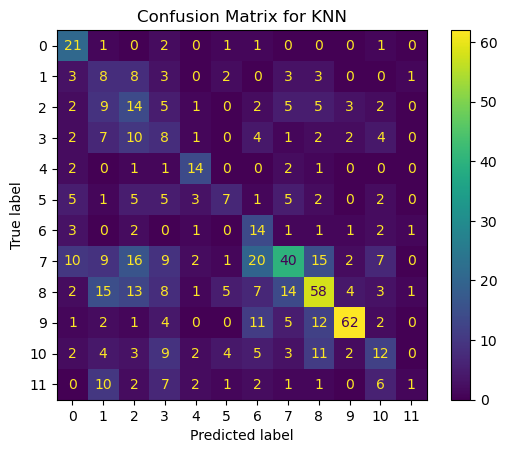

In [25]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for KNN')
plt.show()

In [27]:
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.37976539589442815


## AutoML

In [28]:
train_dataset = pd.DataFrame(X_train)
train_dataset['Class'] = y_train
display(train_dataset)
val_dataset = pd.DataFrame(X_val)
val_dataset['Class'] = y_val
display(val_dataset)

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.027082,-0.013313,-0.008826,-0.072461,0.007343,-0.094076,-0.167494,-0.103801,-0.028412,0.028316,...,-0.068583,-0.076525,0.040421,0.103174,-0.120090,-0.061367,0.000451,-0.059239,-0.118112,A
1,0.037106,-0.005138,-0.000083,-0.078439,-0.025209,-0.128279,-0.140337,-0.093975,0.006738,0.012805,...,-0.104251,-0.081787,0.021214,0.110093,-0.113029,-0.048439,-0.008712,-0.064551,-0.065370,B
2,0.031576,0.001280,-0.010692,-0.077958,0.010638,-0.098438,-0.186385,-0.109000,-0.011298,0.021688,...,-0.099335,-0.075844,0.002399,0.109067,-0.111049,-0.035433,-0.003783,-0.046440,-0.090737,F2
3,0.024698,-0.018922,-0.004377,-0.091306,-0.035864,-0.126389,-0.123579,-0.063004,0.010276,-0.013213,...,-0.045039,-0.072843,0.027239,0.088215,-0.137682,-0.082269,0.006794,-0.121157,-0.082811,C
4,0.023364,0.013839,-0.002473,-0.078658,-0.010952,-0.134258,-0.163767,-0.097279,-0.022913,0.019793,...,-0.060512,-0.083350,0.028553,0.091629,-0.119252,-0.083997,0.002402,-0.086887,-0.085286,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.035753,-0.005854,0.042967,-0.090723,-0.018998,-0.086424,-0.126814,-0.086434,-0.022488,0.006462,...,-0.032203,-0.071346,0.033250,0.070696,-0.102295,0.001881,0.005943,-0.066478,-0.050408,F1
2086,0.003878,-0.010607,-0.001038,-0.083649,-0.008676,-0.110119,-0.115196,-0.039683,-0.016445,-0.032620,...,-0.077235,-0.081901,0.025975,0.113338,-0.130717,-0.073586,0.011626,-0.056790,-0.086503,F1
2087,0.045806,-0.003940,0.017078,-0.088619,-0.022213,-0.112629,-0.126004,-0.057195,0.004902,0.006238,...,-0.067050,-0.063243,0.032363,0.105647,-0.135733,-0.063500,0.004254,-0.063193,-0.095614,E2.2
2088,0.025552,-0.006140,0.019200,-0.075657,-0.014422,-0.122427,-0.153794,-0.069541,-0.009886,0.009537,...,-0.079561,-0.084891,0.027747,0.098194,-0.131920,-0.078182,0.012242,-0.056629,-0.102204,F2


,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,-0.000915,-0.026831,-0.021284,-0.081818,-0.014690,-0.105153,-0.086839,-0.047608,0.011400,-0.040704,...,-0.067567,-0.073468,0.017131,0.098540,-0.160883,-0.090451,0.020652,-0.112683,-0.069740,C
1,0.042952,-0.021889,0.014608,-0.081722,-0.030232,-0.127762,-0.133401,-0.088345,0.009435,0.021749,...,-0.068091,-0.079074,0.005913,0.142875,-0.120805,-0.143977,0.002370,-0.036706,-0.135138,C
2,0.027975,0.001903,0.023916,-0.088942,-0.027335,-0.128155,-0.132155,-0.070465,0.013274,0.004596,...,-0.064180,-0.073080,0.039200,0.125611,-0.137880,-0.042356,0.004591,-0.053066,-0.076129,B
3,0.020103,-0.008271,0.016479,-0.084044,-0.010910,-0.083551,-0.132837,-0.059924,-0.021156,-0.016960,...,-0.051095,-0.075635,0.025732,0.103505,-0.131896,-0.061599,0.003912,-0.068363,-0.055683,C
4,0.027975,0.001903,0.023916,-0.088942,-0.027335,-0.128155,-0.132155,-0.070465,0.013274,0.004596,...,-0.064180,-0.073080,0.039200,0.125611,-0.137880,-0.042356,0.004591,-0.053066,-0.076129,F3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0.007905,-0.004996,-0.015953,-0.093454,0.004775,-0.104667,-0.127955,-0.059922,-0.031785,-0.001099,...,-0.077181,-0.081811,0.042230,0.097166,-0.134426,-0.066036,0.001760,-0.045568,-0.095819,E2.2
678,0.070922,0.013323,0.007459,-0.074777,-0.019818,-0.102601,-0.142620,-0.140584,-0.028153,0.024877,...,-0.061605,-0.057856,0.038696,0.122456,-0.126040,-0.058272,-0.005841,-0.058243,-0.099122,E1
679,0.034509,-0.006053,0.016293,-0.081413,-0.002012,-0.056683,-0.156930,-0.064995,0.001917,-0.005159,...,-0.065306,-0.065418,0.029534,0.108800,-0.138065,-0.039162,0.015397,-0.067361,-0.076355,E2.2
680,0.037305,-0.028905,0.003933,-0.086682,0.000162,-0.086214,-0.120481,-0.066471,-0.006109,-0.016668,...,-0.044886,-0.061259,0.045345,0.067991,-0.137592,-0.007508,-0.002154,-0.074988,-0.030514,F1


In [16]:
from flaml import AutoML


settings = {
    "time_budget": 600,  # total running time in seconds
    # "max_iter": 2,
    "metric": 'micro_f1', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'autoML_classification.log',  # flaml log file
    # "training_data": train_dataset,
    # "validation_data": val_dataset,
    # "label_column_name": "Class",
    "n_jobs": 16, # Give full cpu usage when running on Azure Compute
    "seed": 7654321,    # random seed
}

automl = AutoML()
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **settings)

[flaml.automl.logger: 01-21 08:20:10] {1680} INFO - task = classification
[flaml.automl.logger: 01-21 08:20:10] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 01-21 08:20:10] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-21 08:20:10] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 01-21 08:20:10] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-21 08:20:10] {2219} INFO - iteration 0, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:20:11] {2345} INFO - Estimated sufficient time budget=10976s. Estimated necessary time budget=253s.
[flaml.automl.logger: 01-21 08:20:11] {2392} INFO -  at 1.1s,	estimator lgbm's best error=0.6334,	best estimator lgbm's best error=0.6334
[flaml.automl.logger: 01-21 08:20:11] {2219} INFO - iteration 1, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:20:12] {2392} INFO -  at 2.0s,	estimator lgbm's best error=0.6334,	best estimator lgbm's best error=0.6334
[flaml.automl.logger: 01-21 08:20:12] {2219} INFO - iteration 2, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:20:15] {2392} INFO -  at 5.0s,	estimator lgbm's best error=0.6012,	best estimator lgbm's best error=0.6012
[flaml.automl.logger: 01-21 08:20:15] {2219} INFO - iteration 3, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:20:17] {2392} INFO -  at 7.5s,	estimator xgboost's best error=0.6716,	best estimator lgbm's best error=0.6012
[flaml.automl.logger: 01-21 08:20:17] {2219} INFO - iteration 4, current learner extra_tree
[flaml.automl.logger: 01-21 08:20:17] {2392} INFO -  at 7.5s,	estimator extra_tree's best error=0.7786,	best estimator lgbm's best error=0.6012
[flaml.automl.logger: 01-21 08:20:17] {2219} INFO - iteration 5, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:20:32] {2392} INFO -  at 22.0s,	estimator lgbm's best error=0.5850,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:32] {2219} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 01-21 08:20:32] {2392} INFO -  at 22.0s,	estimator extra_tree's best error=0.7287,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:32] {2219} INFO - iteration 7, current learner extra_tree
[flaml.automl.logger: 01-21 08:20:32] {2392} INFO -  at 22.1s,	estimator extra_tree's best error=0.7287,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:32] {2219} INFO - iteration 8, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:20:35] {2392} INFO -  at 25.1s,	estimator xgboost's best error=0.6496,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:35] {2219} INFO - iteration 9, current learner extra_tree
[flaml.automl.logger: 01-21 08:20:35] {2392} INFO -  at 25.2s,	estimator extra_tree's best error=0.7287,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:35] {2219} INFO - iteration 10, current learner extra_tree
[flaml.automl.logger: 01-21 08:20:35] {2392} INFO -  at 25.3s,	estimator extra_tree's best error=0.7287,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:35] {2219} INFO - iteration 11, current learner extra_tree
[flaml.automl.logger: 01-21 08:20:35] {2392} INFO -  at 25.4s,	estimator extra_tree's best error=0.7287,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:20:35] {2219} INFO - iteration 12, current learner rf
[flaml.automl.logger: 01-21 08:20:35] {2392} INFO -  at 25.7

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:21:07] {2392} INFO -  at 57.2s,	estimator lgbm's best error=0.5850,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:21:07] {2219} INFO - iteration 19, current learner rf


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:21:08] {2392} INFO -  at 58.0s,	estimator rf's best error=0.7170,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:21:08] {2219} INFO - iteration 20, current learner rf
[flaml.automl.logger: 01-21 08:21:08] {2392} INFO -  at 58.2s,	estimator rf's best error=0.7170,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:21:08] {2219} INFO - iteration 21, current learner rf
[flaml.automl.logger: 01-21 08:21:08] {2392} INFO -  at 58.4s,	estimator rf's best error=0.7111,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:21:08] {2219} INFO - iteration 22, current learner xgboost
[flaml.automl.logger: 01-21 08:21:17] {2392} INFO -  at 67.8s,	estimator xgboost's best error=0.5982,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-21 08:21:17] {2219} INFO - iteration 23, current learner xgboost
[flaml.automl.logger: 01-21 08:21:43] {2392} INFO -  at 93.5s,	estimator xgboost's best error=0.5

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:21:46] {2392} INFO -  at 96.3s,	estimator lgbm's best error=0.5850,	best estimator xgboost's best error=0.5806
[flaml.automl.logger: 01-21 08:21:46] {2219} INFO - iteration 27, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:21:55] {2392} INFO -  at 105.5s,	estimator xgboost's best error=0.5806,	best estimator xgboost's best error=0.5806
[flaml.automl.logger: 01-21 08:21:55] {2219} INFO - iteration 28, current learner xgboost
[flaml.automl.logger: 01-21 08:22:10] {2392} INFO -  at 119.9s,	estimator xgboost's best error=0.5806,	best estimator xgboost's best error=0.5806
[flaml.automl.logger: 01-21 08:22:10] {2219} INFO - iteration 29, current learner xgboost
[flaml.automl.logger: 01-21 08:22:58] {2392} INFO -  at 168.7s,	estimator xgboost's best error=0.5806,	best estimator xgboost's best error=0.5806
[flaml.automl.logger: 01-21 08:22:58] {2219} INFO - iteration 30, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:09] {2392} INFO -  at 178.8s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:09] {2219} INFO - iteration 31, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:23] {2392} INFO -  at 193.1s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:23] {2219} INFO - iteration 32, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:26] {2392} INFO -  at 196.5s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:26] {2219} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:26] {2392} INFO -  at 196.6s,	estimator extra_tree's best error=0.7273,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:26] {2219} INFO - iteration 34, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:42] {2392} INFO -  at 212.6s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:42] {2219} INFO - iteration 35, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:45] {2392} INFO -  at 215.1s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:45] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:45] {2392} INFO -  at 215.2s,	estimator extra_tree's best error=0.7229,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:45] {2219} INFO - iteration 37, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:45] {2392} INFO -  at 215.4s,	estimator extra_tree's best error=0.7229,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:45] {2219} INFO - iteration 38, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:45] {2392} INFO -  at 215.5s,	estimator extra_tree's best error=0.7141,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:45] {2219} INFO - iteration 39, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:45] {2392} INFO -  at 215.7s,	estimator extra_tree's best error=0.7141,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:45] {2219} INFO - iteration 40, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:46] {2392} INFO -  at 215.9s,	estimator extra_tree's best error=0.7067,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:46] {2219} INFO - iteration 41, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:46] {2392}

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:23:59] {2392} INFO -  at 229.4s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:59] {2219} INFO - iteration 43, current learner extra_tree
[flaml.automl.logger: 01-21 08:23:59] {2392} INFO -  at 229.6s,	estimator extra_tree's best error=0.7067,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:23:59] {2219} INFO - iteration 44, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:24:00] {2392} INFO -  at 230.5s,	estimator extra_tree's best error=0.6290,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:00] {2219} INFO - iteration 45, current learner extra_tree
[flaml.automl.logger: 01-21 08:24:01] {2392} INFO -  at 230.8s,	estimator extra_tree's best error=0.6290,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:01] {2219} INFO - iteration 46, current learner extra_tree
[flaml.automl.logger: 01-21 08:24:02] {2392} INFO -  at 231.9s,	estimator extra_tree's best error=0.6290,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:02] {2219} INFO - iteration 47, current learner extra_tree
[flaml.automl.logger: 01-21 08:24:02] {2392} INFO -  at 232.3s,	estimator extra_tree's best error=0.6290,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:02] {2219} INFO - iteration 48, current learner rf
[flaml.automl.logger: 01-21 08:24:02] {2392} INFO - 

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:24:08] {2392} INFO -  at 238.3s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:08] {2219} INFO - iteration 52, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:24:25] {2392} INFO -  at 254.9s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:25] {2219} INFO - iteration 53, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:24:34] {2392} INFO -  at 264.2s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:34] {2219} INFO - iteration 54, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:24:38] {2392} INFO -  at 268.2s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:38] {2219} INFO - iteration 55, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:24:39] {2392} INFO -  at 269.4s,	estimator extra_tree's best error=0.6232,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:39] {2219} INFO - iteration 56, current learner xgb_limitdepth
[flaml.automl.logger: 01-21 08:24:56] {2392} INFO -  at 286.6s,	estimator xgb_limitdepth's best error=0.5865,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:24:56] {2219} INFO - iteration 57, current learner xgboost
[flaml.automl.logger: 01-21 08:25:11] {2392} INFO -  at 301.3s,	estimator xgboost's best error=0.5762,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:25:11] {2219} INFO - iteration 58, current learner extra_tree
[flaml.automl.logger: 01-21 08:25:12] {2392} INFO -  at 302.3s,	estimator extra_tree's best error=0.6202,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:25:12] {2219} INFO - iteration 59, current learner xgb_limitdepth
[flaml.automl.logger: 01-21 08:25:19] 

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:25:54] {2392} INFO -  at 343.8s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:25:54] {2219} INFO - iteration 61, current learner xgb_limitdepth


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:26:28] {2392} INFO -  at 378.5s,	estimator xgb_limitdepth's best error=0.5865,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:26:28] {2219} INFO - iteration 62, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:26:30] {2392} INFO -  at 380.1s,	estimator lgbm's best error=0.5674,	best estimator lgbm's best error=0.5674
[flaml.automl.logger: 01-21 08:26:30] {2219} INFO - iteration 63, current learner xgb_limitdepth


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:27:12] {2392} INFO -  at 422.3s,	estimator xgb_limitdepth's best error=0.5630,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:27:12] {2219} INFO - iteration 64, current learner xgb_limitdepth
[flaml.automl.logger: 01-21 08:27:30] {2392} INFO -  at 439.9s,	estimator xgb_limitdepth's best error=0.5630,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:27:30] {2219} INFO - iteration 65, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:27:34] {2392} INFO -  at 444.6s,	estimator lgbm's best error=0.5660,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:27:34] {2219} INFO - iteration 66, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:27:35] {2392} INFO -  at 445.6s,	estimator extra_tree's best error=0.6202,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:27:35] {2219} INFO - iteration 67, current learner xgb_limitdepth
[flaml.automl.logger: 01-21 08:27:53] {2392} INFO -  at 463.4s,	estimator xgb_limitdepth's best error=0.5630,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:27:53] {2219} INFO - iteration 68, current learner extra_tree
[flaml.automl.logger: 01-21 08:27:55] {2392} INFO -  at 465.5s,	estimator extra_tree's best error=0.6202,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:27:55] {2219} INFO - iteration 69, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:28:08] {2392} INFO -  at 478.7s,	estimator lgbm's best error=0.5660,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:28:08] {2219} INFO - iteration 70, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-21 08:28:09] {2392} INFO -  at 479.1s,	estimator extra_tree's best error=0.6202,	best estimator xgb_limitdepth's best error=0.5630
[flaml.automl.logger: 01-21 08:28:09] {2219} INFO - iteration 71, current learner xgb_limitdepth
[flaml.automl.logger: 01-21 08:29:46] {2392} INFO -  at 576.4s,	estimator xgb_limitdepth's best error=0.5543,	best estimator xgb_limitdepth's best error=0.5543
[flaml.automl.logger: 01-21 08:29:46] {2219} INFO - iteration 72, current learner rf
[flaml.automl.logger: 01-21 08:29:46] {2392} INFO -  at 576.7s,	estimator rf's best error=0.7111,	best estimator xgb_limitdepth's best error=0.5543
[flaml.automl.logger: 01-21 08:29:46] {2219} INFO - iteration 73, current learner extra_tree
[flaml.automl.logger: 01-21 08:29:47] {2392} INFO -  at 577.8s,	estimator extra_tree's best error=0.6100,	best estimator xgb_limitdepth's best error=0.5543
[flaml.automl.logger: 01-21 08:29:47] {2219} INFO - iteration 74, current learner extra_tree
[flaml.autom

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgb_limitdepth
Best hyperparmeter config: {'n_estimators': 56, 'max_depth': 6, 'min_child_weight': np.float64(1.7371777222393723), 'learning_rate': np.float64(0.11920119972007695), 'subsample': 1.0, 'colsample_bylevel': np.float64(0.9639115023082855), 'colsample_bytree': np.float64(0.9621235054574703), 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(16.013887670807488)}
Best accuracy on validation data: 0.4457
Training duration of best run: 97.29 s


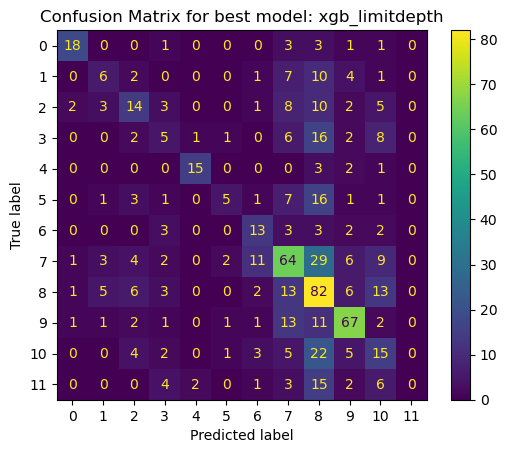

In [51]:
y_pred = automl.predict(X_val)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_val)[:,1]
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

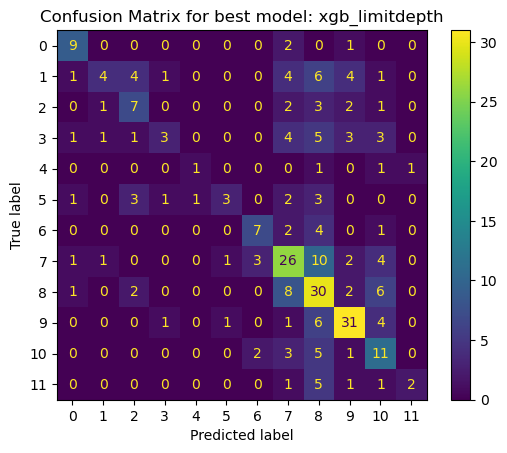

In [40]:
y_pred = automl.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

In [29]:
print('Accuracy:', accuracy_score(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [279, 682]

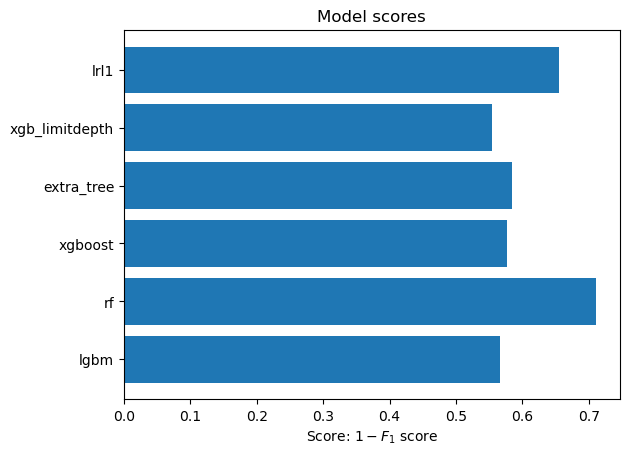

In [36]:
plt.barh(automl.best_loss_per_estimator.keys(), automl.best_loss_per_estimator.values())
plt.xlabel('Score: $1-F_1$ score')
plt.title('Model scores')
plt.show()

In [6]:
automl.best_loss_per_estimator.keys()

NameError: name 'automl' is not defined

## CDR Mean Pool

In [34]:
layer=36
embeddings = esm_output['representations'][layer]
X_cdr = extract_mean_rep(data, embeddings, mean_method='cdr')

In [35]:
X_train = X_cdr[data['partition'] == 'Train']
X_val = X_cdr[data['partition'] == 'Validation']
X_test = X_cdr[data['partition'] == 'Test']
y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

In [36]:
class_count = Counter(y_train)
print(class_count
)
print(min(class_count.values()) / max(class_count.values()))

Counter({'E2.2': 356, 'E3': 319, 'F1': 316, 'F2': 226, 'A': 180, 'C': 150, 'E2.1': 138, 'D1': 122, 'B': 108, 'D2': 63, 'F3': 60, 'E1': 52})
0.14606741573033707


### Oversampling - Do not use

In [ ]:
ros = over_sampling.RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'A': 356,
         'B': 356,
         'F2': 356,
         'C': 356,
         'E2.2': 356,
         'D2': 356,
         'F3': 356,
         'E1': 356,
         'E2.1': 356,
         'D1': 356,
         'E3': 356,
         'F1': 356})

In [ ]:
sm = over_sampling.SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'A': 356,
         'B': 356,
         'F2': 356,
         'C': 356,
         'E2.2': 356,
         'D2': 356,
         'F3': 356,
         'E1': 356,
         'E2.1': 356,
         'D1': 356,
         'E3': 356,
         'F1': 356})

from collections import Counter
Counter(y_res)

## KNN classifier as baseline

In [37]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [38]:
y_pred = neigh.predict(X_val)

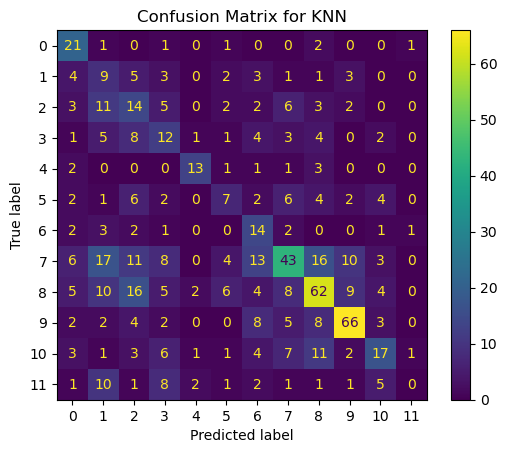

In [39]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for KNN')
plt.show()

In [40]:
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.40762463343108507


## AutoML

In [41]:
train_dataset = pd.DataFrame(X_train)
train_dataset['Class'] = y_train
display(train_dataset)
val_dataset = pd.DataFrame(X_val)
val_dataset['Class'] = y_val
display(val_dataset)

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.043252,0.072683,0.042855,-0.073725,0.018577,-0.091522,-0.181655,-0.092990,0.037061,0.036209,...,-0.056876,-0.015514,0.085547,0.124902,-0.131320,-0.007207,-0.092779,-0.041054,-0.084789,A
1,0.061437,0.056245,0.024487,-0.086864,0.006944,-0.118434,-0.156948,-0.080117,0.049105,0.003954,...,-0.086994,-0.047620,0.066176,0.126077,-0.106619,0.012497,-0.071489,-0.049455,0.000793,B
2,0.069560,0.081303,0.031303,-0.105566,0.038904,-0.084756,-0.205413,-0.109782,0.070213,0.016857,...,-0.067997,-0.023113,0.061442,0.127017,-0.109417,-0.003028,-0.059038,-0.054691,-0.042894,F2
3,0.063967,0.057003,0.033576,-0.093780,0.000299,-0.105917,-0.128271,-0.050570,0.041709,-0.018479,...,-0.060558,-0.016726,0.047174,0.128183,-0.154048,-0.017450,-0.051420,-0.127369,-0.031085,C
4,0.075205,0.081634,0.037149,-0.104874,0.029566,-0.118894,-0.175116,-0.081351,0.030245,0.025451,...,-0.042179,-0.035713,0.085356,0.104165,-0.132707,-0.029635,-0.040184,-0.059261,-0.050365,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.036032,0.069400,0.083863,-0.097580,-0.011969,-0.076862,-0.139238,-0.027624,0.012115,0.016316,...,-0.008938,-0.035577,0.072980,0.101709,-0.103482,0.023392,-0.054240,-0.085937,-0.002443,F1
2086,0.036267,0.046279,0.051569,-0.058172,0.029512,-0.109340,-0.131534,-0.043564,0.038981,-0.012963,...,-0.074688,-0.061749,0.078466,0.113634,-0.151335,0.003225,-0.044762,-0.038964,-0.029941,F1
2087,0.100824,0.085600,0.043680,-0.087364,0.011241,-0.095129,-0.119705,-0.025033,0.047632,0.020174,...,-0.065643,-0.014770,0.078463,0.131052,-0.148332,-0.014985,-0.071555,-0.046811,-0.057487,E2.2
2088,0.049512,0.069644,0.070050,-0.084705,0.009929,-0.109365,-0.162464,-0.046585,0.028938,0.004629,...,-0.074007,-0.047343,0.069047,0.105878,-0.148023,-0.010560,-0.032600,-0.034252,-0.061155,F2


,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.045610,0.027476,0.038892,-0.055843,0.010486,-0.092125,-0.088524,-0.059076,0.044902,-0.022724,...,-0.086153,-0.026617,0.032579,0.130495,-0.185194,-0.043560,-0.038455,-0.098217,-0.033510,C
1,0.080775,0.069291,0.041128,-0.093243,0.022048,-0.100222,-0.150226,-0.083055,0.037842,0.019660,...,-0.050302,-0.037645,0.048087,0.156115,-0.127753,-0.080179,-0.094736,-0.057907,-0.042071,C
2,0.042505,0.070799,0.082090,-0.082763,-0.007396,-0.103019,-0.125514,-0.025697,0.048286,-0.009785,...,-0.064754,-0.040526,0.089341,0.137937,-0.141704,0.011480,-0.052495,-0.030890,-0.040360,B
3,0.079011,0.072792,0.040124,-0.094209,0.013651,-0.042501,-0.151606,-0.076563,0.018184,-0.015755,...,-0.054138,-0.037149,0.070127,0.131281,-0.143289,0.002905,-0.059125,-0.048333,-0.008122,C
4,0.042505,0.070799,0.082090,-0.082763,-0.007396,-0.103019,-0.125514,-0.025697,0.048286,-0.009785,...,-0.064754,-0.040526,0.089341,0.137937,-0.141704,0.011480,-0.052495,-0.030890,-0.040360,F3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0.039687,0.070357,0.005672,-0.097238,0.039244,-0.087399,-0.126398,-0.029475,0.024430,0.015074,...,-0.070456,-0.048213,0.091205,0.090242,-0.139743,-0.006967,-0.040933,-0.034024,-0.049247,E2.2
678,0.089113,0.099590,0.050975,-0.101106,-0.003393,-0.086969,-0.149707,-0.106932,0.054940,0.030239,...,-0.054094,-0.019008,0.083585,0.126228,-0.145512,-0.001693,-0.075911,-0.037597,-0.049647,E1
679,0.080171,0.053475,0.052616,-0.088057,0.017165,-0.051748,-0.189001,-0.074407,0.044561,-0.002528,...,-0.056534,-0.026290,0.078742,0.120994,-0.152553,0.008455,-0.066141,-0.047218,-0.047077,E2.2
680,0.075917,0.028246,0.049015,-0.076641,0.014523,-0.076563,-0.108488,-0.073491,0.021811,0.006280,...,-0.001589,-0.029103,0.089530,0.111080,-0.118346,0.007973,-0.060818,-0.103879,0.022043,F1


In [42]:
settings = {
    "time_budget": 600,  # total running time in seconds
    # "max_iter": 2,
    "metric": 'micro_f1', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'autoML_classification.log',  # flaml log file
    # "training_data": train_dataset,
    # "validation_data": val_dataset,
    # "label_column_name": "Class",
    "n_jobs": 16, # Give full cpu usage when running on Azure Compute
    "seed": 7654321,    # random seed
}

automl = AutoML()
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **settings)

[flaml.automl.logger: 01-22 10:08:19] {1680} INFO - task = classification
[flaml.automl.logger: 01-22 10:08:19] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 01-22 10:08:19] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-22 10:08:19] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 01-22 10:08:19] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-22 10:08:19] {2219} INFO - iteration 0, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:20] {2345} INFO - Estimated sufficient time budget=11197s. Estimated necessary time budget=258s.
[flaml.automl.logger: 01-22 10:08:20] {2392} INFO -  at 1.2s,	estimator lgbm's best error=0.6334,	best estimator lgbm's best error=0.6334
[flaml.automl.logger: 01-22 10:08:20] {2219} INFO - iteration 1, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:21] {2392} INFO -  at 2.0s,	estimator lgbm's best error=0.6334,	best estimator lgbm's best error=0.6334
[flaml.automl.logger: 01-22 10:08:21] {2219} INFO - iteration 2, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:25] {2392} INFO -  at 5.2s,	estimator lgbm's best error=0.5880,	best estimator lgbm's best error=0.5880
[flaml.automl.logger: 01-22 10:08:25] {2219} INFO - iteration 3, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:27] {2392} INFO -  at 7.7s,	estimator xgboost's best error=0.6408,	best estimator lgbm's best error=0.5880
[flaml.automl.logger: 01-22 10:08:27] {2219} INFO - iteration 4, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:27] {2392} INFO -  at 7.8s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5880
[flaml.automl.logger: 01-22 10:08:27] {2219} INFO - iteration 5, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 22.8s,	estimator lgbm's best error=0.5601,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 22.9s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 7, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 23.0s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 8, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 23.1s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 9, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.2s,	estimator extra_tree's best error=0.7302,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:43] {2219} INFO - iteration 10, current learner rf
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.5s,	estimator rf's best error=0.8065,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:43] {2219} INFO - iteration 11, current learner rf
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.6s,	estimator rf's best error=0.7625,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:43] {2219} INFO - iteration 12, current learner rf
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.9s,	estimator rf's best error=

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:09:27] {2392} INFO -  at 68.0s,	estimator lgbm's best error=0.5601,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:09:27] {2219} INFO - iteration 19, current learner extra_tree
[flaml.automl.logger: 01-22 10:09:27] {2392} INFO -  at 68.1s,	estimator extra_tree's best error=0.7273,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:09:27] {2219} INFO - iteration 20, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:09:53] {2392} INFO -  at 93.5s,	estimator xgboost's best error=0.5440,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:09:53] {2219} INFO - iteration 21, current learner xgboost
[flaml.automl.logger: 01-22 10:10:02] {2392} INFO -  at 102.2s,	estimator xgboost's best error=0.5440,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:02] {2219} INFO - iteration 22, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:10:04] {2392} INFO -  at 105.0s,	estimator lgbm's best error=0.5601,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:04] {2219} INFO - iteration 23, current learner rf


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:10:06] {2392} INFO -  at 106.3s,	estimator rf's best error=0.6906,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:06] {2219} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 01-22 10:10:20] {2392} INFO -  at 120.5s,	estimator xgboost's best error=0.5440,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:20] {2219} INFO - iteration 25, current learner extra_tree
[flaml.automl.logger: 01-22 10:10:20] {2392} INFO -  at 120.7s,	estimator extra_tree's best error=0.6774,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:20] {2219} INFO - iteration 26, current learner extra_tree
[flaml.automl.logger: 01-22 10:10:20] {2392} INFO -  at 120.8s,	estimator extra_tree's best error=0.6774,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:20] {2219} INFO - iteration 27, current learner extra_tree
[flaml.automl.logger: 01-22 10:10:20] {2392} I

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:11:26] {2392} INFO -  at 186.5s,	estimator lgbm's best error=0.5601,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:26] {2219} INFO - iteration 43, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:11:26] {2392} INFO -  at 186.8s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:26] {2219} INFO - iteration 44, current learner extra_tree
[flaml.automl.logger: 01-22 10:11:26] {2392} INFO -  at 187.1s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:26] {2219} INFO - iteration 45, current learner extra_tree
[flaml.automl.logger: 01-22 10:11:27] {2392} INFO -  at 187.3s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:27] {2219} INFO - iteration 46, current learner extra_tree
[flaml.automl.logger: 01-22 10:11:27] {2392} INFO -  at 187.7s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:27] {2219} INFO - iteration 47, current learner extra_tree
[flaml.automl.logger: 01-22 10:1

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [43]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 84, 'max_leaves': 6, 'min_child_weight': np.float64(1.3029271408842327), 'learning_rate': np.float64(0.0945622496840656), 'subsample': np.float64(0.977951757291235), 'colsample_bylevel': np.float64(0.9344398385890139), 'colsample_bytree': np.float64(0.9621235054574703), 'reg_alpha': np.float64(0.0041668208198370905), 'reg_lambda': np.float64(7.82506683898272)}
Best accuracy on validation data: 0.4897
Training duration of best run: 80.69 s


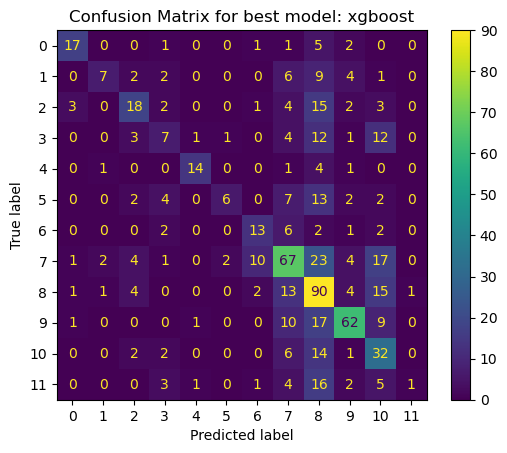

In [44]:
y_pred = automl.predict(X_val)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_val)[:,1]
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

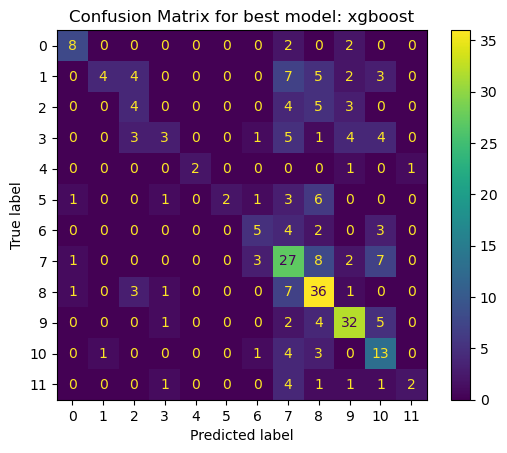

In [45]:
y_pred = automl.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

In [46]:
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.4946236559139785


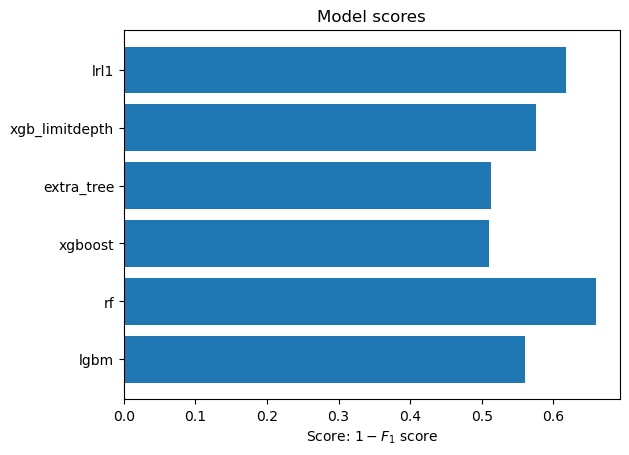

In [47]:
plt.barh(automl.best_loss_per_estimator.keys(), automl.best_loss_per_estimator.values())
plt.xlabel('Score: $1-F_1$ score')
plt.title('Model scores')
plt.show()